In [1]:
import numpy as np
import pandas as pd
import joblib
import os
import random
from tqdm import tqdm
from IPython.core.display_functions import clear_output

random.seed(5)
np.random.seed(5)

# Визуализация
import matplotlib.pyplot as plt

# Torch
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = "1"
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Метрики
from sklearn.metrics import (r2_score,
                             mean_squared_error as MSE,
                             mean_absolute_error as MAE)
# Разделение выборок
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (OrdinalEncoder,
                                   OneHotEncoder,
                                   StandardScaler)
# Создание пайплайна
from sklearn.compose import make_column_transformer

DATA_PATH = '../data'
MODEL_PATH = '../models/'

## Загрузка и подготовка данных

In [2]:
# Загрузим датасет.
# Зададим типы данных в колонках.
dtypes_of_data = {
    'car_make': 'category',
    'car_model': 'category',
    'car_gen': 'category',
    'car_type': 'category',
    'car_compl': 'object',
    #'ann_date':datetime64[ns],
    'car_price': float,
    'ann_city': 'category',
    'avail': 'category',
    'year': int,
    'mileage': float,
    'color': 'category',
    'eng_size': float,
    'eng_power': int,
    'eng_type': 'category',
    'pow_resrv': int,
    'options': 'object',
    'transmission': 'category',
    'drive': 'category',
    'st_wheel': 'category',
    'count_owner': int,
    'original_pts': 'category',
    'state_mark': 'category',
    'class_auto': 'category',
    'door_count': int,
    'long': int,
    'width': int,
    'height': int,
    'clearence': int,
    'v_tank': int,
    'curb_weight': int,
    'front_brakes': 'category',
    'rear_brakes': 'category',
    'max_speed': int,
    'acceleration': float,
    'fuel_cons': float,
    'fuel_brand': 'category',
    'engine_loc1': 'category',
    'engine_loc2': 'category',
    'turbocharg': 'category',
    'max_torq': int,
    'cyl_count': int,
    'seat_count': int,
    'v_bag': int,
    'acc_capacity': int,
    'age': int,
    'age_mod': float,
    'mileage_mod': float,
    'acceleration_mod': float,
    'cyl_count_mod': float
}
try:
    train_all = pd.read_csv(os.path.join(DATA_PATH, 'processed_train.csv'),
                            dtype=dtypes_of_data, parse_dates=['ann_date'])
    test = pd.read_csv(os.path.join(DATA_PATH, 'processed_test.csv'),
                       dtype=dtypes_of_data, parse_dates=['ann_date'])
except:
    print('Changed directory for model to current directory')
    train_all = pd.read_csv('processed_train.csv',
                            dtype=dtypes_of_data, parse_dates=['ann_date'])
    test = pd.read_csv('processed_test.csv',
                       dtype=dtypes_of_data, parse_dates=['ann_date'])
print(f'train {train_all.shape}, test {test.shape}')

train (122898, 50), test (40966, 50)


In [3]:
# Уменьшим избыточную разрядность чисел
fcols = train_all.select_dtypes('floating').columns
icols = train_all.select_dtypes('integer').columns
train_all[fcols] = train_all[fcols].apply(pd.to_numeric, downcast='float')
train_all[icols] = train_all[icols].apply(pd.to_numeric, downcast='integer')
test[fcols] = test[fcols].apply(pd.to_numeric, downcast='float')
test[icols] = test[icols].apply(pd.to_numeric, downcast='integer')

In [4]:
# Рассмотрим общие сведения
train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122898 entries, 0 to 122897
Data columns (total 50 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   car_make          122898 non-null  category      
 1   car_model         122898 non-null  category      
 2   car_gen           122898 non-null  category      
 3   car_type          122898 non-null  category      
 4   car_compl         122898 non-null  object        
 5   car_price         122898 non-null  float32       
 6   ann_city          122898 non-null  category      
 7   avail             122898 non-null  category      
 8   year              122898 non-null  int16         
 9   mileage           122898 non-null  float32       
 10  color             122898 non-null  category      
 11  eng_size          122898 non-null  float32       
 12  eng_power         122898 non-null  int16         
 13  eng_type          122898 non-null  category      
 14  pow_

In [5]:
# Рассмотрим общие сведения
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40966 entries, 0 to 40965
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   car_make          40966 non-null  category      
 1   car_model         40966 non-null  category      
 2   car_gen           40966 non-null  category      
 3   car_type          40966 non-null  category      
 4   car_compl         40966 non-null  object        
 5   car_price         40966 non-null  float32       
 6   ann_city          40966 non-null  category      
 7   avail             40966 non-null  category      
 8   year              40966 non-null  int16         
 9   mileage           40966 non-null  float32       
 10  color             40966 non-null  category      
 11  eng_size          40966 non-null  float32       
 12  eng_power         40966 non-null  int16         
 13  eng_type          40966 non-null  category      
 14  pow_resrv         4096

## Метрики качества

Для информации о качестве моделей будем рассчитывать R2, MSE, MAE.

Возьмём в качестве дополнительной метрики долю верно спрогнозированных цен, при этом ошибка недопрогноза и перепрогноза будет учитываться по-разному:
- по недопрогнозов учитываем те прогнозы, которые в пределах отклонения under_est,
- по перепрогнозам - те прогнозы, которые в пределах отклонения over_est.  
Т.е. среди всех предсказанных цен на авто посчитаем долю прогнозов, отличающихся от реальных цен на эти авто не более чем на `under_est`% в сторону уменьшения и не более чем на `over_est`% в сторону увеличения.

In [6]:
def good_prediction_part(y_true, y_pred, under_est=0.05, over_est=0.10):
    deviations = y_pred / y_true

    result = (((deviations - 1 <= over_est) & (deviations > 1)).sum() +
              ((1 - deviations <= under_est) & (deviations < 1)).sum()) / len(y_true)

    return result

In [39]:
def print_metrics(y_train, y_test, train_pred, test_pred, log_y=False):
    if log_y:
        test_pred = np.exp(test_pred)
        train_pred = np.exp(train_pred)

    print('Обучающая выборка')
    print(f'{"R2": <40} {r2_score(y_train, train_pred): .5}')
    print(f'{"MSE": <40} {MSE(y_train, train_pred): .5}')
    print(f'{"MAE": <40} {MAE(y_train, train_pred): .5}')
    print(f'{"Доля предсказаний 0,95-1,1 от цены": <40} {good_prediction_part(y_train, train_pred): .5}')
    print('Тестовая выборка')
    print(f'{"R2": <40} {r2_score(y_test, test_pred): .5}')
    print(f'{"MSE": <40} {MSE(y_test, test_pred): .5}')
    print(f'{"MAE": <40} {MAE(y_test, test_pred): .5}')
    print(f'{"Доля предсказаний 0,95-1,1 от цены": <40} {good_prediction_part(y_test, test_pred): .5}')

## Подготовка данных

In [8]:
# Список признаков
X = ['car_make', 'car_model', 'car_gen', 'car_type', 'car_compl',
     'ann_city', 'avail', 'year', 'mileage', 'color',
     'eng_size', 'eng_power', 'eng_type', 'pow_resrv', 'options',
     'transmission', 'drive', 'st_wheel', 'count_owner', 'original_pts',
     'state_mark', 'class_auto', 'door_count', 'long', 'width', 'height',
     'v_tank', 'curb_weight', 'front_brakes', 'rear_brakes', 'max_speed',
     'acceleration', 'fuel_cons', 'fuel_brand', 'engine_loc1', 'engine_loc2',
     'turbocharg', 'max_torq', 'cyl_count', 'seat_count', 'clearence',
     'v_bag', 'acc_capacity', 'age', 'age_mod', 'mileage_mod',
     'acceleration_mod', 'cyl_count_mod']

# Целевая переменная
y = 'car_price'

In [9]:
# Составим список числовых признаков
num_features = (
    train_all[X].select_dtypes(
        exclude=['object', 'category']
    ).columns.to_list()
)
num_features

['year',
 'mileage',
 'eng_size',
 'eng_power',
 'pow_resrv',
 'count_owner',
 'door_count',
 'long',
 'width',
 'height',
 'v_tank',
 'curb_weight',
 'max_speed',
 'acceleration',
 'fuel_cons',
 'max_torq',
 'cyl_count',
 'seat_count',
 'clearence',
 'v_bag',
 'acc_capacity',
 'age',
 'age_mod',
 'mileage_mod',
 'acceleration_mod',
 'cyl_count_mod']

In [10]:
# Составим список категориальных признаков
cat_features = train_all[X].select_dtypes(include=['category']).columns.to_list()
cat_features

['car_make',
 'car_model',
 'car_gen',
 'car_type',
 'ann_city',
 'avail',
 'color',
 'eng_type',
 'transmission',
 'drive',
 'st_wheel',
 'original_pts',
 'state_mark',
 'class_auto',
 'front_brakes',
 'rear_brakes',
 'fuel_brand',
 'engine_loc1',
 'engine_loc2',
 'turbocharg']

In [11]:
# Выделим выборку для валидации
train, val = train_test_split(train_all, test_size=0.2)

In [12]:
y_train_all = train_all[y].copy()
y_train = train[y].copy()
y_val = val[y].copy()
X_train_all = train_all[cat_features + num_features].copy()
X_train = train[cat_features + num_features].copy()
X_val = val[cat_features + num_features].copy()
y_test = test[y].copy()
X_test = test[cat_features + num_features].copy()

In [13]:
# Проверим размерность
print(f"X_train {X_train.shape}, y_train {y_train.shape}")
print(f"X_val {X_val.shape}, y_val {y_val.shape}")
print(f"X_test {X_test.shape}, y_test {y_test.shape}")

X_train (98318, 46), y_train (98318,)
X_val (24580, 46), y_val (24580,)
X_test (40966, 46), y_test (40966,)


Признаки будем обрабатывать следующим образом:
- категоиальные с количеством категорий более 20 будем кодировать с помощью эмбеддингов (обучаемые слои в нейронной сети), для чего предварительно закодируем признаки LabelEncoder,
- категориальные с количеством категорий до 20 включительно будем кодировать OHE,  
- числовые будем масштабировать StandardScaler.

In [14]:
# Посмотрим на количество категорий
train[cat_features].nunique().T

car_make         196
car_model       1775
car_gen          367
car_type          26
ann_city        3804
avail              3
color             16
eng_type           9
transmission       4
drive              3
st_wheel           2
original_pts       3
state_mark        23
class_auto         9
front_brakes       3
rear_brakes        3
fuel_brand         8
engine_loc1        4
engine_loc2        3
turbocharg         3
dtype: int64

In [15]:
max_num_of_categories = train[cat_features].nunique().T.max()

In [16]:
# Выделим списки признаков для разной обработки
cat_features_to_embed = train[cat_features].nunique().T[train[cat_features].nunique().T > 20].index.to_list()
cat_features_to_OHE = train[cat_features].nunique().T[train[cat_features].nunique().T <= 20].index.to_list()
cat_features_to_embed, cat_features_to_OHE

(['car_make', 'car_model', 'car_gen', 'car_type', 'ann_city', 'state_mark'],
 ['avail',
  'color',
  'eng_type',
  'transmission',
  'drive',
  'st_wheel',
  'original_pts',
  'class_auto',
  'front_brakes',
  'rear_brakes',
  'fuel_brand',
  'engine_loc1',
  'engine_loc2',
  'turbocharg'])

In [17]:
# Определим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ),
        cat_features_to_embed
    ),
    (
        OneHotEncoder(
            handle_unknown='ignore',
            drop='first',
            sparse_output=False
        ),
        cat_features_to_OHE
    ),
    (
        StandardScaler(),
        num_features
    ), remainder='passthrough',
    verbose_feature_names_out=False
)
col_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['car_make', 'car_model', 'car_gen',
                                  'car_type', 'ann_city', 'state_mark']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['avail', 'color', 'eng_type', 'transmission',
                                  'driv...
                                ('standardscaler', StandardScaler(),
                                 ['year', 'mileage', 'eng_size', 'eng_power',
                                  'pow_resrv', 'count_owner', 'door_count',
                                  'long', 'width', 'height', 'v_tank',
                                  'curb_weight', 'max_speed', 'acceleration',
                                  'fuel_cons', 'max_torq', 'cyl_count',
                                  'seat_count', 'clearence', 'v_bag',
                                  'acc_capacity', 'age', 'age_mod',
                                  'mileage_mod', 'acceleration_mod',
                                  'cyl_count_mod'])],
                  verbose_feature_names_out=False)

In [18]:
# Обозначим размеры эмбеддингов для признаков (чем больше категорий - тем длиннее)
# ['car_make', 'car_model', 'car_gen', 'car_type', 'ann_city', 'state_mark']
embed_dims = [4, 16, 8, 2, 32, 2]

In [19]:
# Обучим трансформер и применим к обучающей выборке
col_transformer.fit(X_train)
X_train = col_transformer.transform(X_train)
# Обученный трансформер применим к валидационной выборке
X_val = col_transformer.transform(X_val)
# Проверим размерность
print(f"X_train {X_train.shape}, y_train {y_train.shape}")
print(f"X_val {X_val.shape}, y_val {y_val.shape}")

X_train (98318, 91), y_train (98318,)
X_val (24580, 91), y_val (24580,)


### Эксперименты с нейронной сетью

In [20]:
# Выберем device для вычислений
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
device

device(type='cuda', index=0)

In [21]:
# Создадим класс для датасета
class CarPriceDataset(Dataset):
    def __init__(self, X, y, embed_features):
        """
            X: DataFrame с признаками после преобразования
            y: Целевая переменная (цена)
            embed_features: Список признаков для эмбеддинга
        """
        # Числовые признаки (в том числе после OHE) преобразуем в тензор
        self.X_num = torch.FloatTensor(
            X.drop(columns=embed_features).values
        )

        # Целевую переменную преобразуем в тензор
        self.y = torch.FloatTensor(y.values).unsqueeze(1)

        # Категориальные признаки (убедимся, что индексы в допустимых пределах)
        self.X_embed = torch.stack([
            torch.LongTensor(X[feat].values)
            for feat in embed_features
        ], dim=1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            self.X_num[idx],  # Числовые признаки
            self.X_embed[idx],  # Все embed-признаки вместе
            self.y[idx]  # Целевая переменная
        )


# Создаем датасеты
train_dataset = CarPriceDataset(X_train, y_train, embed_features=cat_features_to_embed)
val_dataset = CarPriceDataset(X_val, y_val, embed_features=cat_features_to_embed)

# Параметры загрузки
batch_size = 1024
num_workers = 0
to_use_pin_memory = (device.type == 'cuda')

# Создаём генераторы батчей
# для трейна
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=to_use_pin_memory
    # так быстрее, но нельзя уйти в swap (часть данных система тащит на диск, если оперативки не хватает)
)
# для валидации
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=to_use_pin_memory
)

In [22]:
# Создадим класс сети
class CarPriceModel(nn.Module):
    def __init__(self, num_numeric_features, embed_features, embed_dims, category_sizes):
        """
            num_numeric_features: общее количество числовых признаков (исходные числовые + после OHE)
            embed_features: список имен признаков для эмбеддинга
            embed_dims: список размерностей эмбеддингов
            category_sizes: список размеров категорий (кол-во уникальных значений)
        """
        super().__init__()

        # Создаем Embedding слои
        # Добавляем +1 к количеству эмбеддингов для неизвестных категорий (значение -1)
        self.embed_layers = nn.ModuleList([
            nn.Embedding(num_embeddings=size + 1, embedding_dim=dim)
            for size, dim in zip(category_sizes, embed_dims)
        ])

        # Расчёт общего размера входа
        total_features = num_numeric_features + sum(embed_dims)

        # Основная сеть
        self.net = nn.Sequential(
            nn.Linear(total_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 128),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),

            nn.Linear(128, 64),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),

            nn.Linear(64, 32),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),

            # Выходной слой с ReLU (чтоб цены были не отрицательными)
            nn.Linear(32, 1),
            nn.ReLU(inplace=True)
        )

        # Инициализация весов
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, x_num, x_embed):
        # Преобразуем -1 в последний индекс эмбеддинга
        # За счёт broadcasting тензор растягивается в размер заменяемого
        # и замена -1 в каждом столбце происходит на свой индекс
        x_embed = torch.where(
            x_embed == -1,
            torch.tensor([emb.num_embeddings - 1 for emb in self.embed_layers]).to(x_embed.device),
            x_embed
        )
        # Обработка эмбеддингов
        embedded = [
            embed_layer(x_embed[:, i])
            for i, embed_layer in enumerate(self.embed_layers)
        ]
        # Конкатенация всех признаков
        x = torch.cat([x_num] + embedded, dim=1)

        return self.net(x)

In [23]:
# Функция для контроля процесса обучения и валидации
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    """
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="train")
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label="val")
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label="train")
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label="val")

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale("log")

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale("log")

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    axs[0].set_ylabel("MSE loss")
    axs[1].set_ylabel("R2")
    plt.show()

In [33]:
def train_and_validate(
        model,
        optimizer,
        criterion,
        metric,
        train_loader,
        val_loader,
        num_epochs,
        y_train,
        y_val,
        verbose=True,
):
    """
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
      - y_train: target train,
      - y_val: target val (test)     
    """
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    device = next(model.parameters()).device

    # Вычисляем общую дисперсию для R2
    y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
    total_variance = np.sum((y_train_np - np.mean(y_train_np)) ** 2)

    y_val_np = y_val.values if hasattr(y_val, 'values') else y_val
    total_var_val = np.sum((y_val_np - np.mean(y_val_np)) ** 2)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_train_loss = 0
        pbar = (
            tqdm(train_loader, desc=f"Training {epoch}/{num_epochs}")
            if verbose
            else train_loader
        )

        for i, (x_num, x_embed, y_batch) in enumerate(pbar, 1):  # берём батч из загрузчика обучающих батчей
            x_num = x_num.to(device, non_blocking=False)
            x_embed = x_embed.to(device, non_blocking=False)
            y_batch = y_batch.to(device, non_blocking=False)
            y_pred = model(x_num, x_embed)  # делаем предсказания
            loss = criterion(y_pred, y_batch)  # считаем лосс
            loss.backward()  # считаем градиенты обратным проходом
            optimizer.step()  # обновляем параметры сети
            optimizer.zero_grad(  # обнуляем (или set to None) посчитанные градиенты параметров
                set_to_none=True)  #set_to_none ускоряет, т.к. не присваивает всем элементам 0,
            # а делает None весь тензор, не поэлементно, но если на градиенты есть планы, то лучше обнулять

            with torch.no_grad():  # запрещаем фреймворку считать градиенты по параметрам где не требуется
                predictions = y_pred.cpu().numpy()
                metric_value = metric(predictions, y_batch.cpu().numpy())
                # кросс энтропия в Torch усредняет по батчу (по умолчанию, но это
                # настраивается), чтоб получить сумму лосса, умножаем на размер батча
                epoch_train_loss += loss.item() * x_num.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"MSE loss": loss.item(), "R2": metric_value})  # По батчам

        train_losses += [epoch_train_loss / len(train_loader.dataset)]
        train_metrics += [1 - epoch_train_loss / total_variance]
        # Валидация
        model.eval()
        epoch_val_loss = 0
        val_pbar = (
            tqdm(val_loader, desc=f"Validating {epoch}/{num_epochs}")
            if verbose
            else val_loader
        )

        for i, (x_num, x_embed, y_batch) in enumerate(val_pbar,
                                                      1):  # берём батч из загрузчика валидационных батчей        
            with torch.no_grad():  # запрещаем фреймворку считать градиенты по параметрам где не требуется
                x_num = x_num.to(device, non_blocking=False)
                x_embed = x_embed.to(device, non_blocking=False)
                y_batch = y_batch.to(device, non_blocking=False)
                y_pred = model(x_num, x_embed)  # делаем предсказания
                loss = criterion(y_pred, y_batch)  # считаем лосс
                epoch_val_loss += loss.item() * x_num.shape[0]

                if verbose and i % 100 == 0:
                    pbar.set_postfix({"Val MSE loss": loss.item()})  # По батчам

        val_losses += [epoch_val_loss / len(val_loader.dataset)]
        val_metrics += [1 - epoch_val_loss / total_var_val]

        if verbose:
            print(f"Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
            print(f"Train R2: {train_metrics[-1]:.4f}, Val R2: {val_metrics[-1]:.4f}")
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    return train_metrics[-1], val_metrics[-1]

In [25]:
# Вычисляем размеры категорий
category_sizes = [
    int(X_train[feat].max() + 1)  # +1 потому что индексы с 0
    for feat in cat_features_to_embed
]

In [26]:
# Инициализация модели
model = CarPriceModel(
    num_numeric_features=X_train.drop(columns=cat_features_to_embed).shape[1],
    embed_features=cat_features_to_embed,
    embed_dims=embed_dims,
    category_sizes=category_sizes
).to(device)

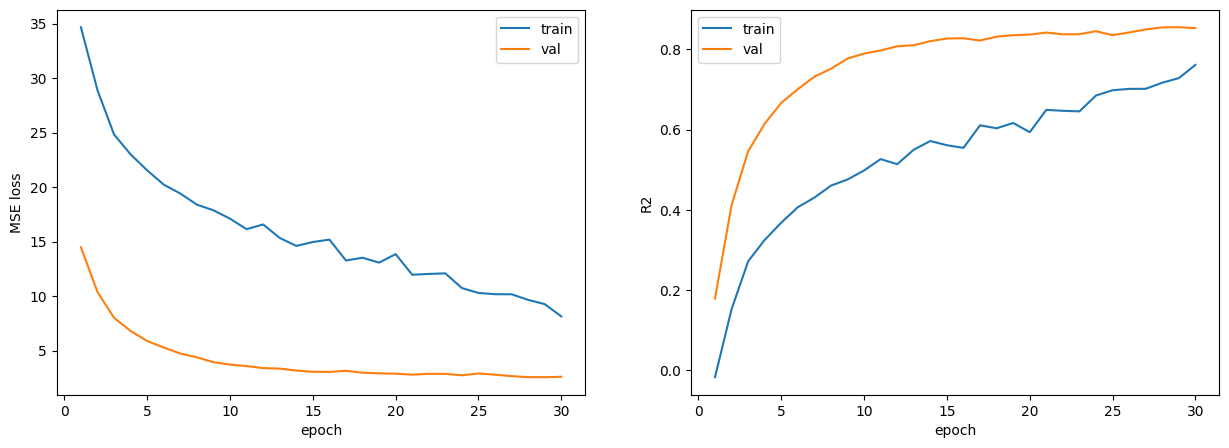

(0.7613349147929538, 0.8530386054920839)

In [45]:
# Обучим модель
train_and_validate(
    model=model,
    optimizer=torch.optim.Adam(model.parameters(), lr=5e-5,
                               fused=True),  # fused=True даёт ускорение, нововведение в Torch
    criterion=torch.nn.MSELoss(),
    metric=lambda pred, y: r2_score(y, pred),
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=30,
    y_train=y_train,
    y_val=y_val,
    verbose=True
)

Обучим на всей выборке для обучения

In [28]:
# Обучим трансформер и применим к обучающей выборке
col_transformer.fit(X_train_all)
X_train_all = col_transformer.transform(X_train_all)
# Обученный трансформер применим к тестовой выборке
X_test = col_transformer.transform(X_test)
# Проверим размерность
print(f"X_train {X_train_all.shape}, y_train {y_train_all.shape}")
print(f"X_test {X_test.shape}, y_test {y_test.shape}")

X_train (122898, 91), y_train (122898,)
X_test (40966, 91), y_test (40966,)


In [29]:
# Вычисляем размеры категорий
category_sizes = [
    int(X_train_all[feat].max() + 1)  # +1 потому что индексы с 0
    for feat in cat_features_to_embed
]

In [30]:
# Инициализация модели
model = CarPriceModel(
    num_numeric_features=X_train_all.drop(columns=cat_features_to_embed).shape[1],
    embed_features=cat_features_to_embed,
    embed_dims=embed_dims,
    category_sizes=category_sizes
).to(device)

In [32]:
# Создаем датасеты
train_all_dataset = CarPriceDataset(X_train_all, y_train_all, embed_features=cat_features_to_embed)
test_dataset = CarPriceDataset(X_test, y_test, embed_features=cat_features_to_embed)

# Параметры загрузки
batch_size = 1024
num_workers = 0
to_use_pin_memory = (device.type == 'cuda')

# Создаём генераторы батчей
# для трейна
train_all_loader = DataLoader(
    train_all_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=to_use_pin_memory
    # так быстрее, но нельзя уйти в swap (часть данных система тащит на диск, если оперативки не хватает)
)

# для теста
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=to_use_pin_memory
)

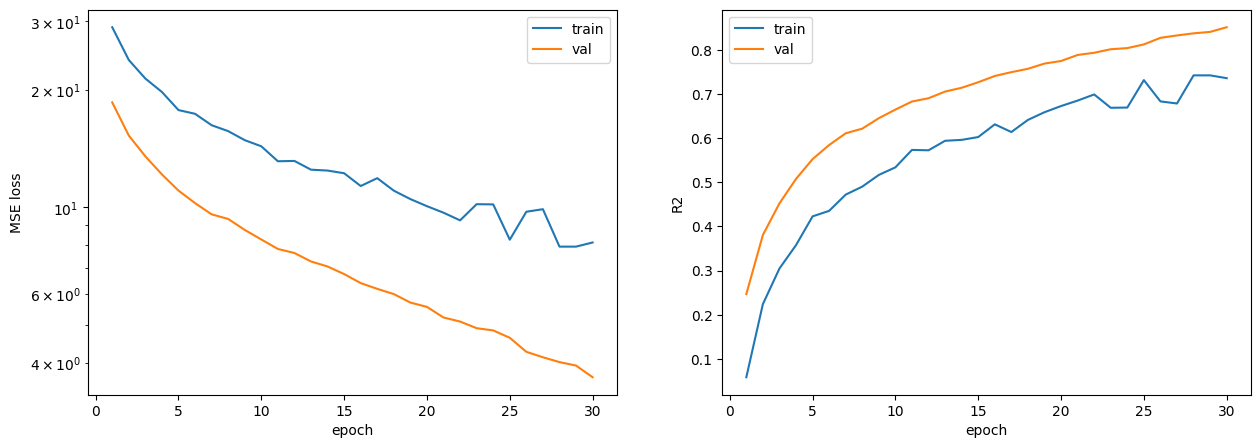

(0.7359536757856642, 0.8514144893094058)

In [34]:
# Обучим модель
train_and_validate(
    model=model,
    optimizer=torch.optim.Adam(model.parameters(), lr=5e-5,
                               fused=True),  # fused=True даёт ускорение, нововведение в Torch
    criterion=torch.nn.MSELoss(),
    metric=lambda pred, y: r2_score(y, pred),
    train_loader=train_all_loader,
    val_loader=test_loader,
    num_epochs=30,
    y_train=y_train_all,
    y_val=y_test,
    verbose=True
)

In [38]:
# Получение предсказаний
model.eval()
y_pred_train = np.array([])
for i, (x_num, x_embed, y_batch) in enumerate(train_loader, 1):  # берём батч из загрузчика обучающих батчей        
    with torch.no_grad():
        x_num = x_num.to(device, non_blocking=False)
        x_embed = x_embed.to(device, non_blocking=False)
        y_batch = y_batch.to(device, non_blocking=False)
        y_pred = model(x_num, x_embed)  # делаем предсказания
        y_pred_train = np.concatenate([y_pred_train, y_pred.cpu().numpy().flatten()])

y_pred_test = np.array([])
for i, (x_num, x_embed, y_batch) in enumerate(test_loader, 1):  # берём батч из загрузчика тестовых батчей        
with torch.no_grad():
    x_num = x_num.to(device, non_blocking=False)
    x_embed = x_embed.to(device, non_blocking=False)
    y_batch = y_batch.to(device, non_blocking=False)
    y_pred = model(x_num, x_embed)  # делаем предсказания
    y_pred_test = np.concatenate([y_pred_test, y_pred.cpu().numpy().flatten()])

In [42]:
# Вычислим метрики
print_metrics(y_train=y_train_all,
              y_test=y_test,
              train_pred=y_pred_train,
              test_pred=y_pred_test,
              log_y=False)

Обучающая выборка
R2                                       -0.58392
MSE                                       48.779
MAE                                       2.4365
Доля предсказаний 0,95-1,1 от цены        0.03594
Тестовая выборка
R2                                        0.85141
MSE                                       3.669
MAE                                       0.57607
Доля предсказаний 0,95-1,1 от цены        0.11422


Улучшить метрики по сравнению с классическими и бустинговыми моделями не удалось. Возможно, требуется больше эпох. Остановимся на данном этапе на бустинговых моделях, которые дали лучшие результаты.